**Оглавление**<a id='toc0_'></a>    
- [Загрузка данных](#toc1_)    
- [Исследование данных](#toc2_)    
  - [Общая информация](#toc2_1_)    
  - [Преобразование типов](#toc2_2_)    
  - [Проверка пропусков](#toc2_3_)    
  - [Размеры групп](#toc2_4_)    
  - [Проверка пересечений](#toc2_5_)    
  - [Базовые расчеты](#toc2_6_)    
    - [Общая конверсия](#toc2_6_1_)    
    - [Конверсия по дням недели](#toc2_6_2_)    
    - [Конверсия по часам](#toc2_6_3_)    
    - [Проверка нормальности распределения](#toc2_6_4_)    
    - [Доверительные интервалы](#toc2_6_5_)    
  - [Выводы о данных](#toc2_7_)    
- [A/B тестирование](#toc3_)    
  - [Выбор статистического теста](#toc3_1_)    
  - [Статистический тест](#toc3_2_)    
    - [Полные группы](#toc3_2_1_)    
    - [Стратифицирование](#toc3_2_2_)    
    - [Бустраппирование](#toc3_2_3_)    
- [Выводы](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Загрузка данных](#toc0_)

In [ ]:
import pandas as pd
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.api import DescrStatsW
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

In [ ]:
df = pd.read_csv('./data/marketing_AB.csv', index_col=[0])

# <a id='toc2_'></a>[Исследование данных](#toc0_)

## <a id='toc2_1_'></a>[Общая информация](#toc0_)

In [ ]:
# 1. Исследование структуры данных
print("Информация о датасете:")
print(df.info())  # Общая информация о столбцах


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB
None


In [5]:
print("\nПример данных:")
df.sample(15)# примеры данных


Пример данных:


,user id,test group,converted,total ads,most ads day,most ads hour
130343,1167125,ad,False,22,Saturday,20
94081,1261974,ad,False,163,Monday,11
151636,1505271,ad,False,97,Monday,13
531301,1653797,ad,False,14,Saturday,9
470316,1502401,ad,False,17,Friday,15
42242,1588415,ad,False,54,Friday,19
496290,1653602,ad,False,3,Friday,22
49528,911800,psa,False,1,Thursday,9
109932,1006914,ad,False,18,Friday,14
101903,1301015,ad,False,7,Saturday,17


## <a id='toc2_2_'></a>[Преобразование типов](#toc0_)

Преобразование не требуется   
converted - уже имеет тип bool
total ads - int64 

## <a id='toc2_3_'></a>[Проверка пропусков](#toc0_)

In [ ]:
# 3. Проверка на наличие пропусков
print("\nКоличество пропусков по столбцам:")
print(df.isnull().sum())

# Удаление строк с пропусками не требуется ввиду их отсутствия


Количество пропусков по столбцам:
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64


## <a id='toc2_4_'></a>[Размеры групп](#toc0_)

In [ ]:
# Создаем два поднабора данных: контрольная группа и тестовая группа
control_group = df[df["test group"] == "psa"]
test_group = df[df["test group"] == "ad"]
print(f'Размер тестовой группы = {test_group.shape[0]}')
print(f'Размер контрольной группы = {control_group.shape[0]}')

Размер тестовой группы = 564577
Размер контрольной группы = 23524


## <a id='toc2_5_'></a>[Проверка пересечений](#toc0_)

In [ ]:

# Ищем пользователей, которые находятся в обеих группах
overlap_users = set(control_group["user id"]).intersection(set(test_group["user id"]))
print("\nКоличество пользователей, попавших в обе группы:", len(overlap_users))

# Очистка не требуется


Количество пользователей, попавших в обе группы: 0


## <a id='toc2_6_'></a>[Базовые расчеты](#toc0_)

### <a id='toc2_6_1_'></a>[Общая конверсия](#toc0_)

In [ ]:
# Рассчитываем конверсию в процентах
control_conversion_percent = control_group['converted'].mean() * 100
test_conversion_percent = test_group['converted'].mean() * 100

print(f"Конверсия в контрольной группе (PSA): {control_conversion_percent:.2f}%")
print(f"Конверсия в тестовой группе (AD): {test_conversion_percent:.2f}%")

Конверсия в контрольной группе (PSA): 1.79%
Конверсия в тестовой группе (AD): 2.55%


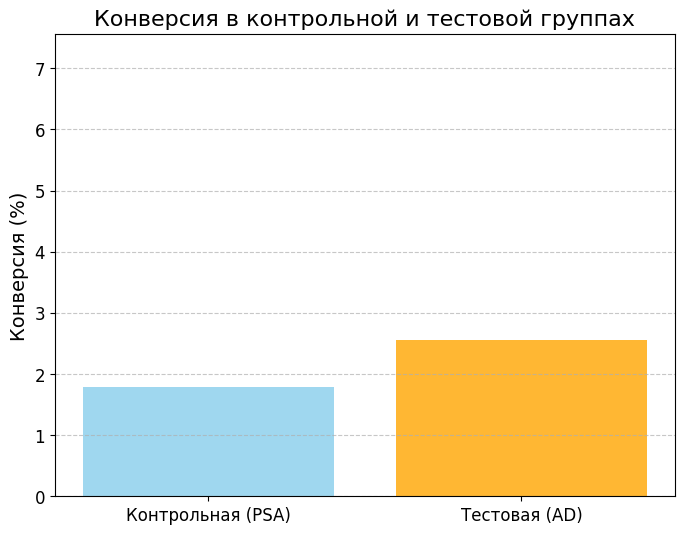

In [ ]:
# Данные для графика
groups = ['Контрольная (PSA)', 'Тестовая (AD)']
conversion_rates = [
    control_conversion_percent,  # Конверсия контрольной группы в процентах
    test_conversion_percent     # Конверсия тестовой группы в процентах
]

# Построение столбчатого графика
plt.figure(figsize=(8, 6))
plt.bar(groups, conversion_rates, color=['skyblue', 'orange'], alpha=0.8)
plt.title('Конверсия в контрольной и тестовой группах', fontsize=16)
plt.ylabel('Конверсия (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(conversion_rates) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### <a id='toc2_6_2_'></a>[Конверсия по дням недели](#toc0_)

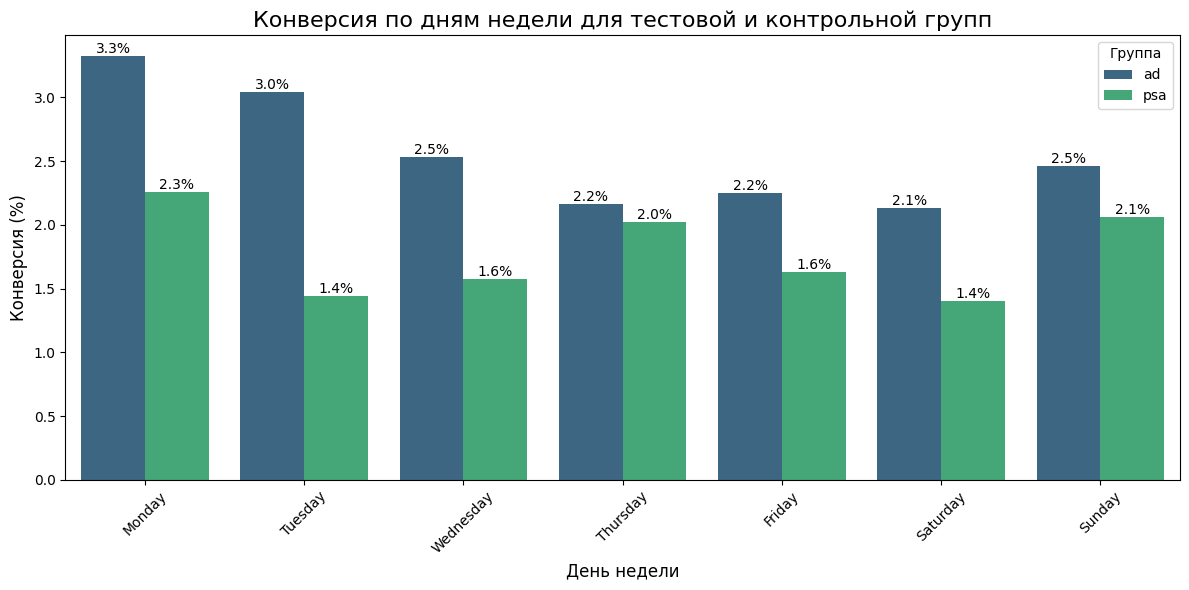

In [ ]:
# Подсчет конверсии по дням недели и группам
conversion_by_day = (
    df.groupby(['most ads day', 'test group'])
    .agg(conversion_rate=('converted', 'mean'), user_count=('user id', 'count'))
    .reset_index()
)

# Преобразуем данные для удобства визуализации
conversion_by_day['conversion_rate'] *= 100  # Перевод в проценты

# Порядок дней недели
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
conversion_by_day['most ads day'] = pd.Categorical(conversion_by_day['most ads day'], categories=day_order, ordered=True)

# Построение графика
plt.figure(figsize=(12, 6))
ax =sns.barplot(
    data=conversion_by_day,
    x='most ads day',
    y='conversion_rate',
    hue='test group',
    palette='viridis'
)

# Добавление подписей процентов над столбцами
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.1f%%',  # Формат значений (проценты с одной цифрой после запятой)
        label_type='edge',
        fontsize=10
    )
plt.title('Конверсия по дням недели для тестовой и контрольной групп', fontsize=16)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Конверсия (%)', fontsize=12)
plt.legend(title='Группа', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### <a id='toc2_6_3_'></a>[Конверсия по часам](#toc0_)

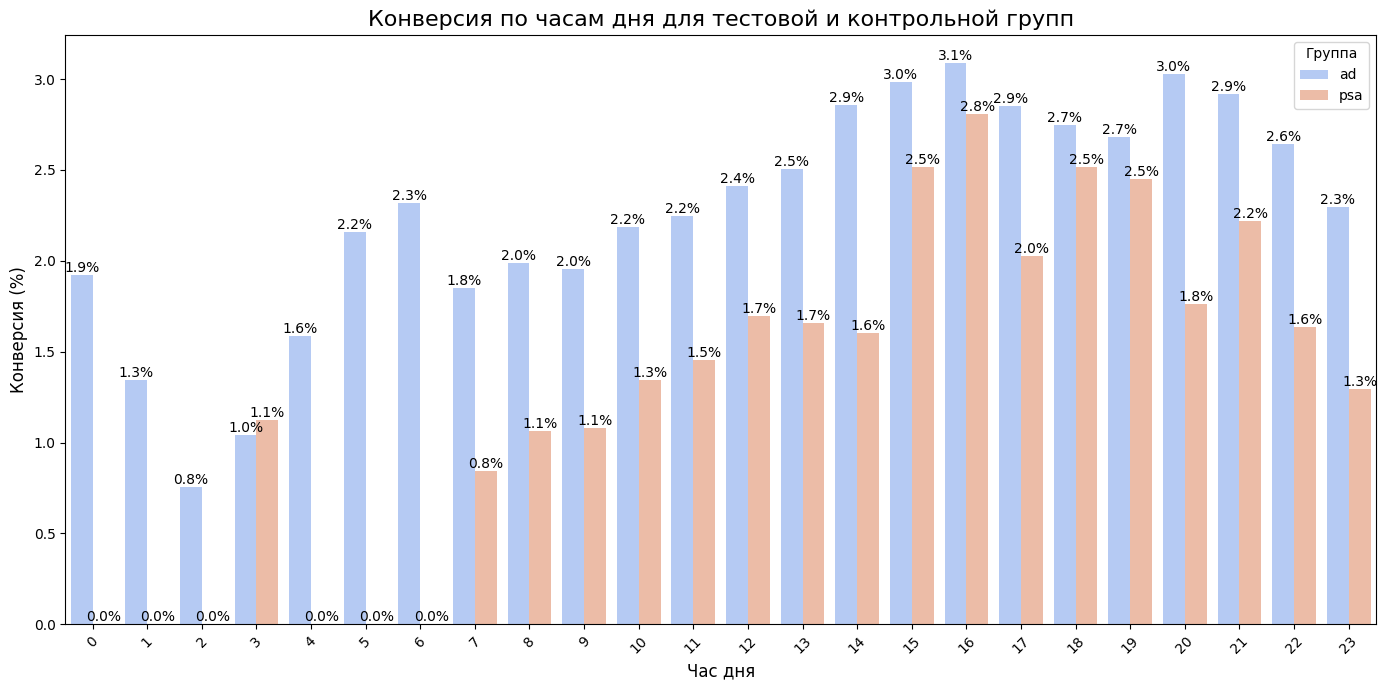

In [ ]:
# Подсчет конверсии по часам и группам
conversion_by_hour = (
    df.groupby(['most ads hour', 'test group'])
    .agg(conversion_rate=('converted', 'mean'), user_count=('user id', 'count'))
    .reset_index()
)

# Преобразуем данные для удобства визуализации
conversion_by_hour['conversion_rate'] *= 100  # Перевод в проценты

# Построение графика
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=conversion_by_hour,
    x='most ads hour',
    y='conversion_rate',
    hue='test group',
    palette='coolwarm'
)

# Добавление подписей процентов над столбцами
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.1f%%',  # Формат значений (проценты с одной цифрой после запятой)
        label_type='edge',
        fontsize=10
    )

plt.title('Конверсия по часам дня для тестовой и контрольной групп', fontsize=16)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Конверсия (%)', fontsize=12)
plt.legend(title='Группа', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [138]:
# Отфильтровать данные по количеству показов от 0 до 6 и конверсии
filtered_data = df[(df['most ads hour'] >= 0) &  (df['most ads hour'] <= 6)]

# Подсчитать количество конверсии в этой категории
purchases_in_range = filtered_data['converted'].sum()

# Подсчитать общее количество конверсии
total_purchases = df['converted'].sum()

# Рассчитать процент
percentage = (purchases_in_range / total_purchases) * 100

print(f"Процент конверсии с количеством показов от 0 до 6 часов по отношению к общему числу конверсии: {percentage:.2f}%")

Процент конверсии с количеством показов от 0 до 6 часов по отношению к общему числу конверсии: 2.05%


### <a id='toc2_6_4_'></a>[Проверка нормальности распределения](#toc0_)

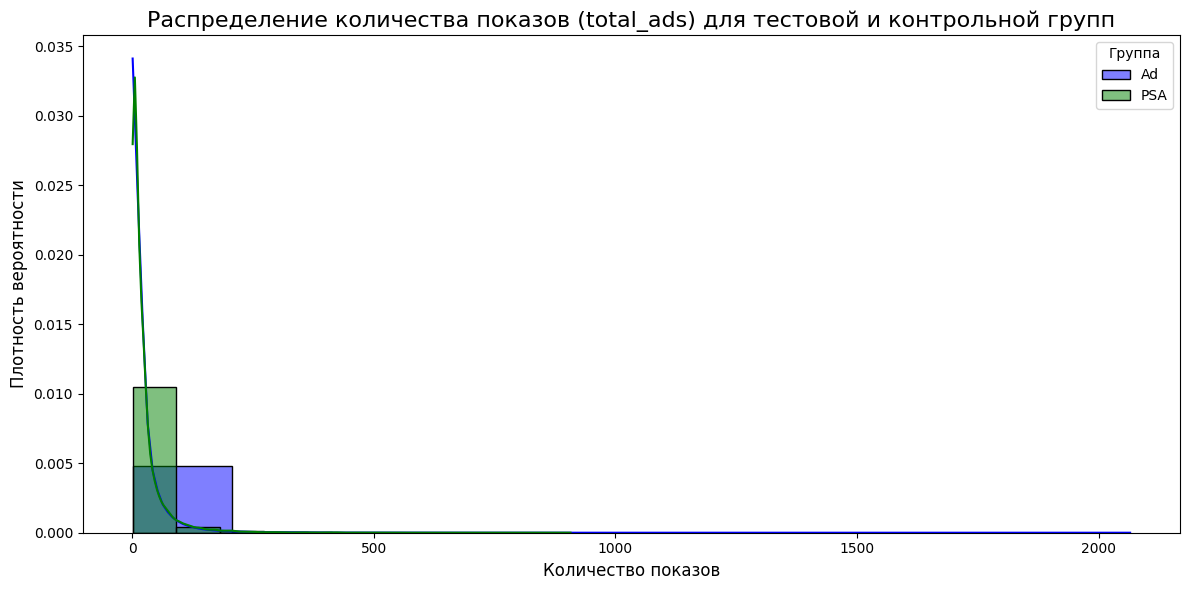

In [ ]:
# Построение графика для "total_ads" по группам
plt.figure(figsize=(12, 6))

# Гистограмма для группы "ad"
sns.histplot(df[df['test group'] == 'ad']['total ads'], kde=True, color='blue', label='Ad', bins=10, stat='density')

# Гистограмма для группы "psa"
sns.histplot(df[df['test group'] == 'psa']['total ads'], kde=True, color='green', label='PSA', bins=10, stat='density')

# Настройка графика
plt.title('Распределение количества показов (total_ads) для тестовой и контрольной групп', fontsize=16)
plt.xlabel('Количество показов', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend(title='Группа')
plt.tight_layout()

# Показать график
plt.show()

In [ ]:
# Для каждой группы проверим нормальность для конверсии и количества показов
for group in ['ad', 'psa']:
    # Данные для выбранной группы
    group_data = df[df['test group'] == group]
    
    # Проверка нормальности для конверсии
    conversion_data = group_data['converted']
    stat_conv, p_value_conv = stats.kstest(conversion_data,'norm')
    
    # Проверка нормальности для количества показов
    ads_data = group_data['total ads']
    stat_ads, p_value_ads = stats.kstest(ads_data,'norm')
    
    print(f"Группа '{group}':")
    
    # Результаты для конверсии
    print(f"  Конверсия - Статистика Kolmogorov-Smirnov: {stat_conv:.3f}, p-value: {p_value_conv:.3f}")
    if p_value_conv > 0.05:
        print(f"    Распределение для конверсии нормально (p > 0.05)")
    else:
        print(f"    Распределение для конверсии ненормальное (p <= 0.05)")
    
    # Результаты для количества показов
    print(f"  Количество показов - Статистика Kolmogorov-Smirnov: {stat_ads:.3f}, p-value: {p_value_ads:.3f}")
    if p_value_ads > 0.05:
        print(f"    Распределение для количества показов нормально (p > 0.05)\n")
    else:
        print(f"    Распределение для количества показов ненормальное (p <= 0.05)\n")

Группа 'ad':
  Конверсия - Статистика Kolmogorov-Smirnov: 0.500, p-value: 0.000
    Распределение для конверсии ненормальное (p <= 0.05)
  Количество показов - Статистика Kolmogorov-Smirnov: 0.881, p-value: 0.000
    Распределение для количества показов ненормальное (p <= 0.05)

Группа 'psa':
  Конверсия - Статистика Kolmogorov-Smirnov: 0.500, p-value: 0.000
    Распределение для конверсии ненормальное (p <= 0.05)
  Количество показов - Статистика Kolmogorov-Smirnov: 0.879, p-value: 0.000
    Распределение для количества показов ненормальное (p <= 0.05)



### <a id='toc2_6_5_'></a>[Доверительные интервалы](#toc0_)

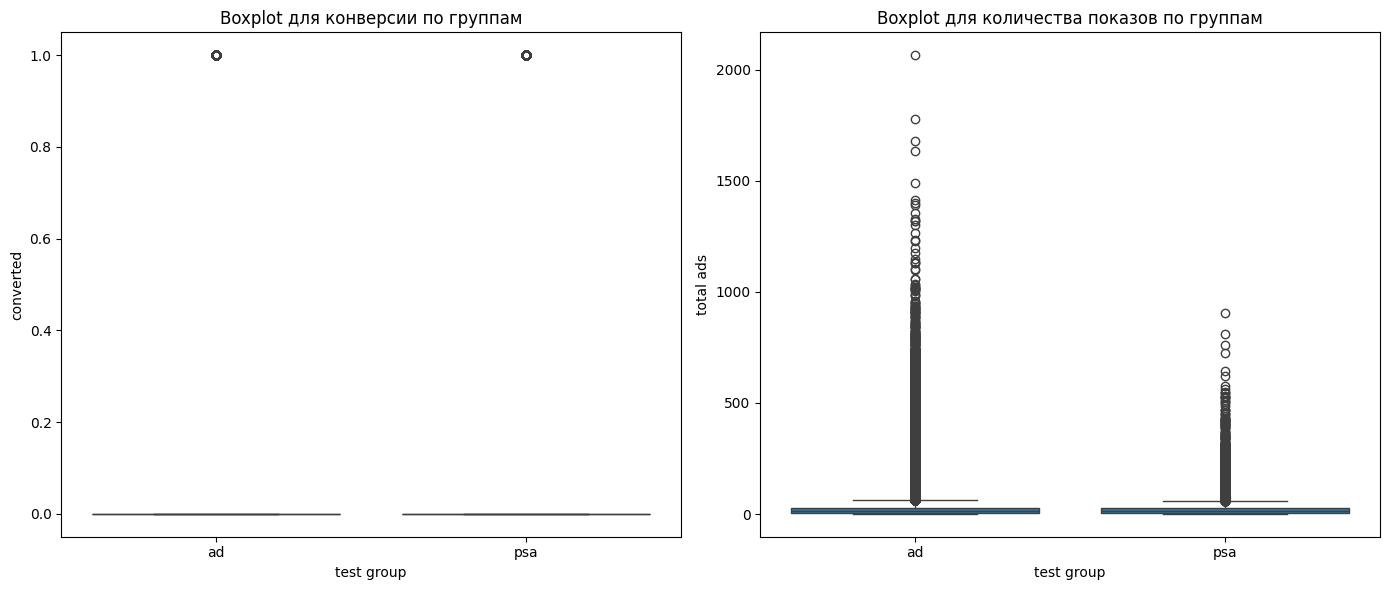

In [ ]:
# Построение графиков boxplot для конверсии и количества показов по группам
plt.figure(figsize=(14, 6))

# 1. Boxplot для конверсии
plt.subplot(1, 2, 1)
sns.boxplot(x='test group', y='converted', data=df)
plt.title('Boxplot для конверсии по группам')

# 2. Boxplot для количества показов
plt.subplot(1, 2, 2)
sns.boxplot(x='test group', y='total ads', data=df)
plt.title('Boxplot для количества показов по группам')

# Настройка отображения
plt.tight_layout()
plt.show()

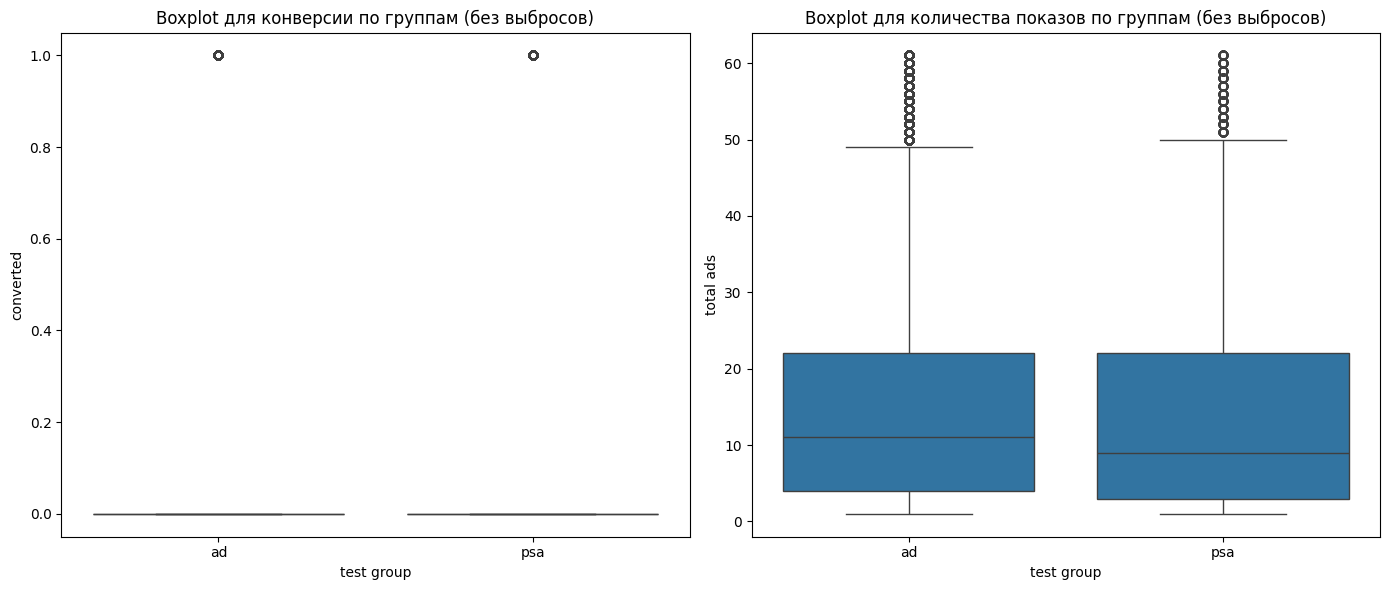

In [36]:
# Удалим выбросы для большей наглядности 
# Функция для удаления выбросов по методу IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Убираем выбросы для переменных
data_no_outliers = remove_outliers(df, 'total ads')

# Построение графиков boxplot для конверсии и количества показов по группам без выбросов
plt.figure(figsize=(14, 6))

# 1. Boxplot для конверсии
plt.subplot(1, 2, 1)
sns.boxplot(x='test group', y='converted', data=data_no_outliers)
plt.title('Boxplot для конверсии по группам (без выбросов)')

# 2. Boxplot для количества показов
plt.subplot(1, 2, 2)
sns.boxplot(x='test group', y='total ads', data=data_no_outliers)
plt.title('Boxplot для количества показов по группам (без выбросов)')

# Настройка отображения
plt.tight_layout()
plt.show()

In [135]:
def get_bernoulli_confidence_interval(values: np.array):
    """Вычисляет доверительный интервал для параметра распределения Бернулли.

    :param values: массив элементов из нулей и единиц.
    :return (left_bound, right_bound): границы доверительного интервала.
    """
    
    n = len(values)
    z = 1.96
    p = np.mean(values)
    sigma = np.sqrt(p * (1-p))
    
    interval = z * sigma / np.sqrt(n)
    
    return (np.clip(p - interval, 0, 1), np.clip(p + interval, 0, 1))

In [ ]:
print(f"Группа ad':")
print(f"  Доверительный интервал для конверсии: {get_bernoulli_confidence_interval(df[df['test group']=='ad']['converted'])}")
print(f"  Доверительный интервал для конверсии: {get_bernoulli_confidence_interval(df[df['test group']=='psa']['converted'])}")

Группа ad':
  Доверительный интервал для конверсии: (0.02513499198005383, 0.025958127293313666)
  Доверительный интервал для конверсии: (0.01616188362021982, 0.019546329268744642)


## <a id='toc2_7_'></a>[Выводы о данных](#toc0_)


1. В данных нет нормального распределения 
2. Данные контрольной и тестовой групп имеют не пересекающиеся доверительные интервалы по конверсии
3. на основании грубой оценки можно предположить, что имеется эффект от рекламы(около 40 процентов, но это требуется доказать статистически)
4. Имеется сильный дисбаланс групп. Размер тестовой группы = 564577 Размер контрольной группы = 23524
5. имеется интересная аномалия в ночные часы (с 0 до 6) - почти полная эффективность рекламы, за исключением 3х часов ночи. но на долю ночи прижодится всего 2 процента конверсии. потому отложим это на дальнейшие исследования

# <a id='toc3_'></a>[A/B тестирование](#toc0_)

Наша цель проверить гипотезу, что показываемая пользователям реклама не оказывает статистически значимого эффекта.
Для этого выделяем контрольную группу, которой будем показывать объявление государственной службы (PSA) (или ничего) точно такого же размера и в том же месте, где обычно находится реклама

Принимаем за нулевую гипотезу, то что реклама не эффективна. и попробуем отвергнуть эту гипотезу.


## <a id='toc3_1_'></a>[Выбор статистического теста](#toc0_)


Для описанных  условий лучшим выбором статистического теста будет Критерий Манна-Уитни (Mann-Whitney U Test), который является непараметрическим тестом и подходит для сравнения двух независимых групп, когда данные не следуют нормальному распределению и наблюдения  независимы .


Преимущества Манна-Уитни:

    * Это непараметрический тест, который работает с рангами данных, и не требует, чтобы данные следовали нормальному распределению.
    * Он позволяет выявить статистически значимые различия в распределениях между группами, даже если данные сильно отличаются от нормальных.

## <a id='toc3_2_'></a>[Статистический тест](#toc0_)

### <a id='toc3_2_1_'></a>[Полные группы](#toc0_)

In [ ]:
control_group = df[df["test group"] == "psa"]['converted']
test_group = df[df["test group"] == "ad"]['converted']
# Применяем тест Манна-Уитни для конверсий
stat, p_value = stats.mannwhitneyu(control_group, test_group)

# Вывод результатов
print(f"Статистика теста Манна-Уитни: {stat}")
print(f"P-значение: {p_value}")

# Интерпретация p-значения
if p_value < 0.05:
    print("Мы отвергаем нулевую гипотезу: разница между группами статистически значимая.")
else:
    print("Нет статистически значимой разницы между группами.")

Статистика теста Манна-Уитни: 6589472518.0
P-значение: 1.7053617930171878e-13
Мы отвергаем нулевую гипотезу: разница между группами статистически значимая.


### <a id='toc3_2_2_'></a>[Стратифицирование](#toc0_)

In [ ]:
df_control = df[df["test group"] == "psa"]  # Контрольная группа
df_test = df[df["test group"] == "ad"]  # Тестовая группа

n_control = df_control.shape[0]  # размер контрольной группы

# 1. Определение ближайших соседей для каждой строки тестовой группы
knn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')  # ищем ближайшего соседа

# Обучаем модель на контрольных данных по количеству показов
knn.fit(df_control[['total ads']])

# Находим ближайших соседей для каждой строки тестовой группы
_ , indices = knn.kneighbors(df_test[['total ads']])

# Получаем индексы ближайших соседей из тестовой группы для каждой строки из контрольной
df_test['nearest_control'] = [df_control.iloc[indices[i][0]]['total ads'] for i in range(len(indices))]

# 2. Выборка из тестовой группы, которая по размеру равна контрольной
# Мы выбираем строки из тестовой группы, у которых ближайшие соседи (nearest_control) равны строкам контрольной группы
df_test_matched = df_test.loc[df_test['nearest_control'].isin(df_control['total ads'])]

# Чтобы сделать размер выборки тестовой группы равным контрольной, выбираем случайные строки (если нужно)
df_test_strat = df_test_matched.sample(n=n_control, random_state=42)


C:\Users\rvv19\AppData\Local\Temp\ipykernel_35264\4186930354.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['nearest_control'] = [df_control.iloc[indices[i][0]]['total ads'] for i in range(len(indices))]


In [ ]:
control_group = df_control['converted']
test_group = df_test_strat['converted']
# Применяем тест Манна-Уитни для конверсий
stat, p_value = stats.mannwhitneyu(control_group, test_group)

# Вывод результатов
print(f"Статистика теста Манна-Уитни: {stat}")
print(f"P-значение: {p_value}")

# Интерпретация p-значения
if p_value < 0.05:
    print("Мы отвергаем нулевую гипотезу: разница между группами статистически значимая.")
else:
    print("Нет статистически значимой разницы между группами.")

Статистика теста Манна-Уитни: 274136934.0
P-значение: 1.4708802511417923e-11
Мы отвергаем нулевую гипотезу: разница между группами статистически значимая.


### <a id='toc3_2_3_'></a>[Бустраппирование](#toc0_)

Среднее p-значение: 0.0082
Стандартное отклонение p-значений: 0.0382
Мы отвергаем нулевую гипотезу: разница между группами статистически значимая.


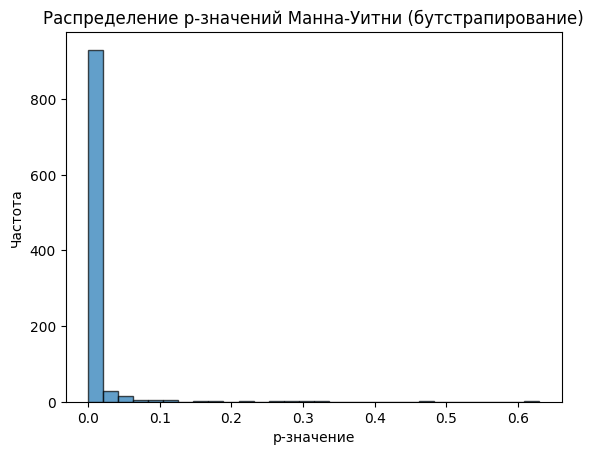

In [ ]:

# Функция для выполнения теста Манна-Уитни и бутстрапирования
def mann_whitney_bootstrap(control_data, test_data, n_bootstrap=5000, n_iterations=100):
    p_values = []  # Список для хранения p-значений
    
    # Повторяем бутстрапирование n_iterations раз
    for _ in range(n_iterations):
        # Бутстрапирование (выборка с повтором)
        control_sample = np.random.choice(control_data, size=n_bootstrap, replace=True)
        test_sample = np.random.choice(test_data, size=n_bootstrap, replace=True)
        
        # Выполнение теста Манна-Уитни
        _, p_value = stats.mannwhitneyu(control_sample, test_sample, alternative='two-sided')
        
        # Добавляем p-значение в список
        p_values.append(p_value)
    
    return np.array(p_values)

# Выполнение бутстрапирования
p_values = mann_whitney_bootstrap(df_control['converted'], df_test['converted'],10000,1000)

# Вычисление среднего p-значения и его стандартного отклонения
mean_p_value = np.mean(p_values)
std_p_value = np.std(p_values)

# Вывод результатов
print(f"Среднее p-значение: {mean_p_value:.4f}")
print(f"Стандартное отклонение p-значений: {std_p_value:.4f}")


# Интерпретация p-значения
if mean_p_value < 0.05:
    print("Мы отвергаем нулевую гипотезу: разница между группами статистически значимая.")
else:
    print("Нет статистически значимой разницы между группами.")
    
    
# Дополнительно: гистограмма p-значений
import matplotlib.pyplot as plt

plt.hist(p_values, bins=30, edgecolor='black', alpha=0.7)
plt.title("Распределение p-значений Манна-Уитни (бутстрапирование)")
plt.xlabel("p-значение")
plt.ylabel("Частота")
plt.show()

# <a id='toc4_'></a>[Выводы](#toc0_)

Нам удалось обпровергнуть нулевую гипотезу.
И соответствено мы подтвердили первоначальное предположение об эффективности рекламной компании.

использование критерия Манна-Уитни на полной тестовой выборке из-за дисбаланса показало самые оптимистичные результаты.  
но даже при использовании страптификации и бутстрапирования мы подтвердили первоначальное предположение об эффективности рекламной компании.

